# A generational model of support for gun control

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import pandas as pd
import numpy as np

import utils

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1', 6)

In [2]:
def read_samples(iters=101):
    """Read samples.
    
    iters: number of times to run
    """
    for i in range(iters):
        key = 'iter%d' % i
        sample = pd.read_hdf('iterations2021.hdf', key)
        yield sample

In [3]:
for sample in read_samples(1):
    pass

sample.shape

(45546, 59)

In [4]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [5]:
def get_percentiles(series_seq, ps=None):
    if ps is None:
        ps = [0.05, 0.5, 0.95]
    ps = np.asarray(ps)
    xs, rows = percentile_rows(series_seq, ps)
    return xs, rows

In [6]:
def plot_percentiles(series_seq, color, label, plot=True, fill=True, alpha=0.2):
    """Plots 90% CI and median.
    
    series_seq: sequence of Series
    color: string color
    label: string label
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    xs, rows = get_percentiles(series_seq)
    if fill:
        plt.fill_between(xs, rows[0], rows[2], color=color, alpha=alpha, lw=0)
    if plot:
        plt.plot(xs, rows[1], color=color, label=label)

## Favor gunlaw

In [7]:
for sample in read_samples(1):
    pass

In [8]:
def make_series(grouped, varname):
    """Compute the percentage in each category.
    
    grouped: GroupBy object
    varname: string column name
    
    returns:  Series
    """
    return grouped[varname].mean() * 100

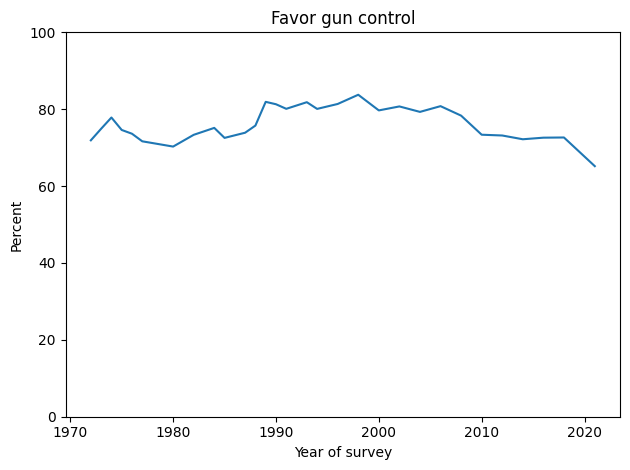

In [9]:
grouped_year = sample.groupby('year')
favor = make_series(grouped_year, 'favor').dropna()
plt.plot(favor)
utils.decorate(xlabel='Year of survey', 
                 ylabel='Percent', ylim=[0, 100],
                 title='Favor gun control')

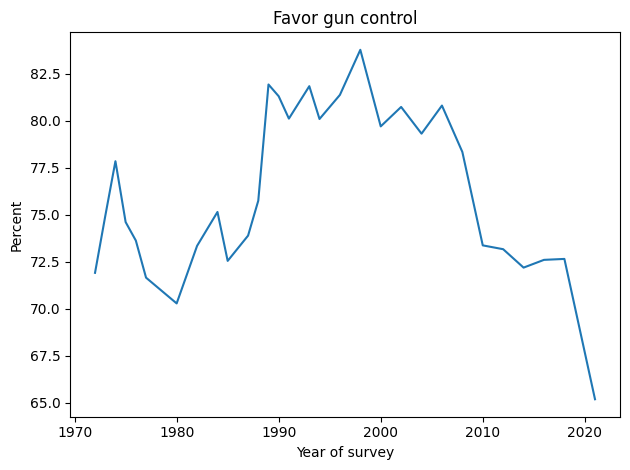

In [10]:
grouped_year = sample.groupby('year')
favor = make_series(grouped_year, 'favor').dropna()
plt.plot(favor)
utils.decorate(xlabel='Year of survey', 
                 ylabel='Percent',
                 title='Favor gun control')

In [11]:
favor_seq = []

for sample in read_samples(101):
    grouped_year = sample.groupby('year')
    favor = make_series(grouped_year, 'favor').dropna()
    favor_seq.append(favor)

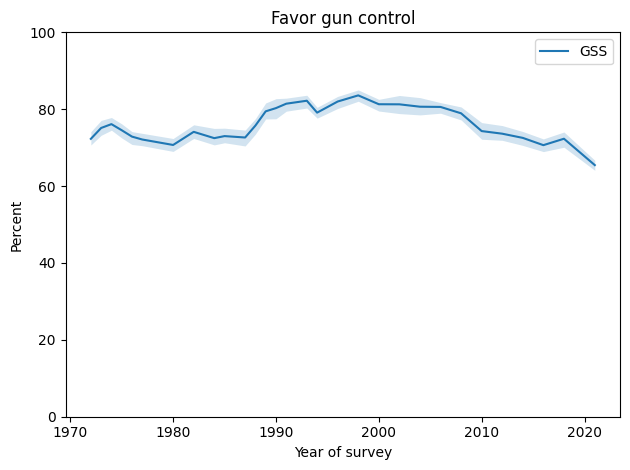

In [12]:
plot_percentiles(favor_seq, 'C0', 'GSS')

utils.decorate(title='Favor gun control',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=[0, 100])

In [13]:
ylim=[40, 100]

Writing gss_year.png


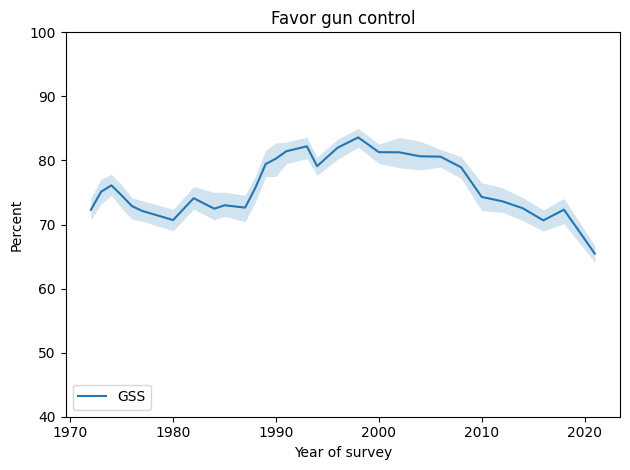

In [14]:
plot_percentiles(favor_seq, 'C0', 'GSS')

utils.decorate(title='Favor gun control',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim,
                 loc='lower left')

plt.tight_layout()
utils.save('gss_year')

In [15]:
heri = pd.read_csv('heri_gun_control.csv')

In [16]:
def plot_heri(heri, x='year'):
    heri1 = heri.loc[:21]
    heri2 = heri.loc[22]
    plt.plot(heri1[x], heri1.agree, color=ORANGE, label='CIRP')
    plt.plot(heri2[x], heri2.agree, '^', color=ORANGE)

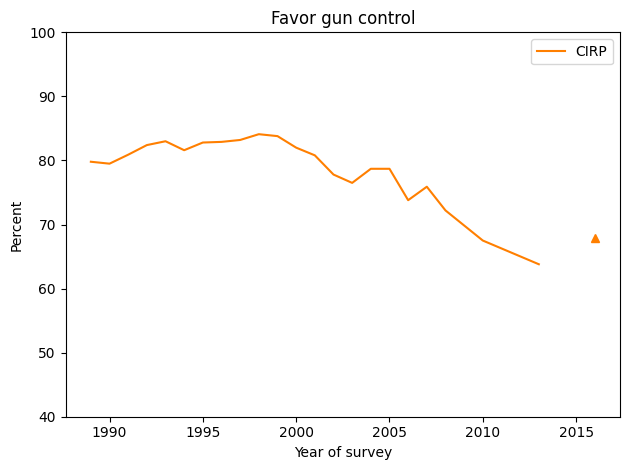

In [17]:
plot_heri(heri)

utils.decorate(title='Favor gun control',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim)

Writing heri_year.png


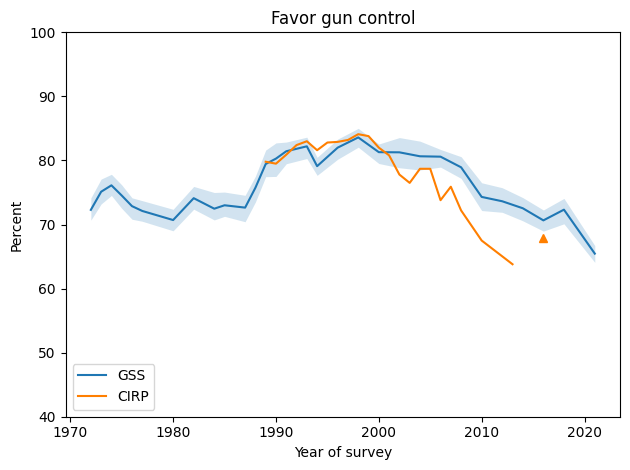

In [18]:
plot_percentiles(favor_seq, 'C0', 'GSS')
plot_heri(heri)

utils.decorate(title='Favor gun control',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim,
                 loc='lower left')

plt.tight_layout()
utils.save('heri_year')

In [19]:
def read_pew():
    pew = pd.read_csv('Pew Gun Data - Sheet1.csv', header=None).transpose()
    pew = pew.drop(columns=[3])
    pew.columns = ['Date', 'Total rights', 'Total control']
    pew = pew.drop(0)
    date = pd.DatetimeIndex(pew.Date)
    pew.index = date.year + date.dayofyear / 365
    return pew

In [20]:
pew = read_pew()

In [21]:
def plot_pew(pew):
    series = pew['Total control'].astype(int)
    plt.plot(series.index, series, color='C2', label='Pew')

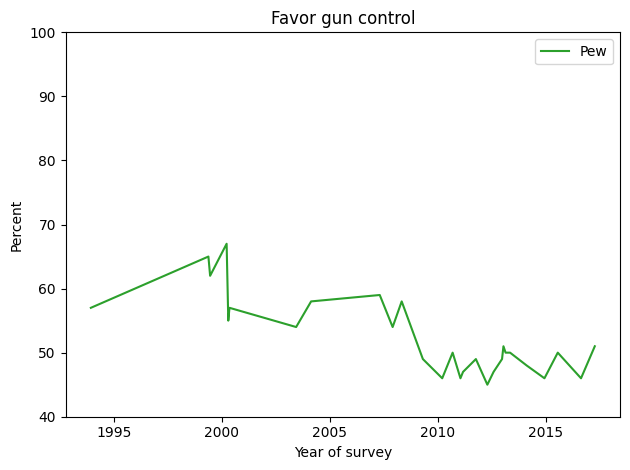

In [22]:
plot_pew(pew)

utils.decorate(title='Favor gun control',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim)

Writing pew_year.png


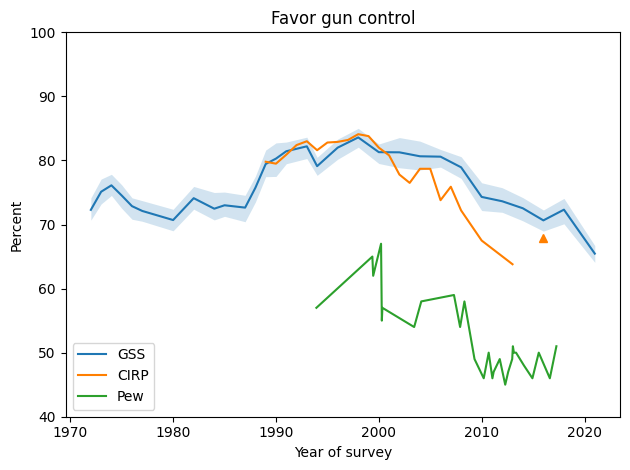

In [23]:
plot_percentiles(favor_seq, 'C0', 'GSS')
plot_heri(heri)
plot_pew(pew)

utils.decorate(title='Favor gun control',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim,
                 loc='lower left')

plt.tight_layout()
utils.save('pew_year')

## Plot by year of birth

In [76]:
def chunk_series(df, xvarname, yvarname, n=200):
    """Break a population into chunks and compute a mean for each chunk.

    Sort by `xvarname`, break into chunks, and compute the mean of column "y"

    df: DataFrame
    xvarname: variable
    size: chunk size

    returns: pd.Series
    """
    subset = df[[xvarname, yvarname]].dropna().sort_values(by=xvarname).reset_index()
    size = len(subset) // n + 1
    subset["chunk"] = subset.index // size
    groupby = subset.groupby("chunk")
    # print(groupby[xvarname].count())
    x = groupby[xvarname].mean()
    y = groupby[yvarname].mean()

    return pd.Series(y.values, x)

In [77]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series, frac=0.666):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x, frac=frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [78]:
def plot_series_lowess(series, color, plot_series=False, frac=0.7, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    if "label" not in options:
        options["label"] = series.name
  
    if plot_series or len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.3, label='_')

    if not plot_series and len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.6, label=options['label'])

    if len(series) > 1:
        smooth = make_lowess(series, frac=frac)
        smooth.plot(color=color, **options)

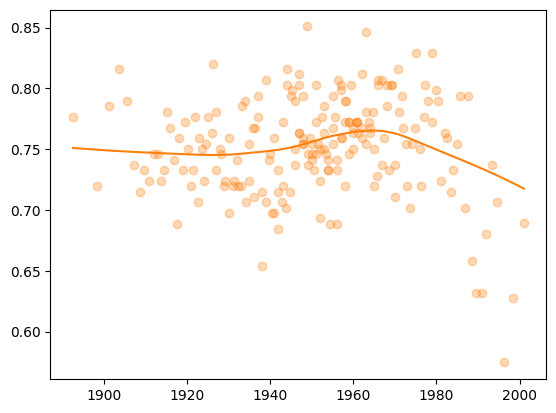

In [79]:
series = chunk_series(sample, 'cohort', 'favor')
plot_series_lowess(series, 'C1', plot_series=True)

In [130]:
from scipy.interpolate import interp1d

def interpolate(series, **options):
    """Creates an interpolation function.
    series: Series object
    options: any legal options to scipy.interpolate.interp1d
    returns: function that maps from the index to the values
    """
    # make the interpolate function extrapolate past the ends of
    # the range, unless `options` already specifies a value for `fill_value`
    options['fill_value'] = "extrapolate"

    # call interp1d, which returns a new function object
    x = series.index
    y = series.values
    interp_func = interp1d(x, y, **options)
    return interp_func

In [140]:
favor_cohort_seq = []
xs = np.arange(1890, 2001)

for sample in read_samples(101):
    series = chunk_series(sample, 'cohort', 'favor', n=200)
    smooth = make_lowess(series)
    ys = interpolate(smooth)(xs) * 100
    favor_cohort_seq.append(pd.Series(ys, xs))

In [141]:
ylim=[50, 100]

Writing gss_favor_cohort.png


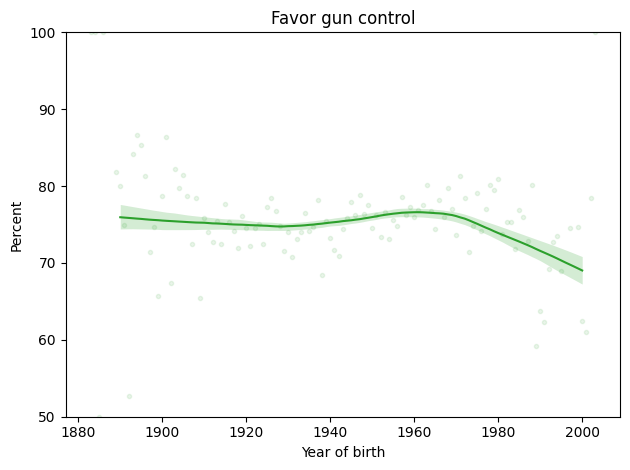

In [142]:
series = sample.groupby('cohort')['favor'].mean() * 100
series.plot(style='.', color='C2', alpha=0.1, label='')

plot_percentiles(favor_cohort_seq, 'C2', "")

utils.decorate(title='Favor gun control',
               xlabel='Year of birth', 
               ylabel='Percent', ylim=ylim)

utils.save('gss_favor_cohort')

In [143]:
favor_time_year = []
xs = np.arange(1973, 2022)

for sample in read_samples(101):
    series = chunk_series(sample, 'year', 'favor', n=200)
    smooth = make_lowess(series)
    ys = interpolate(smooth)(xs) * 100
    favor_time_year.append(pd.Series(ys, xs))

Writing gss_favor_year.png


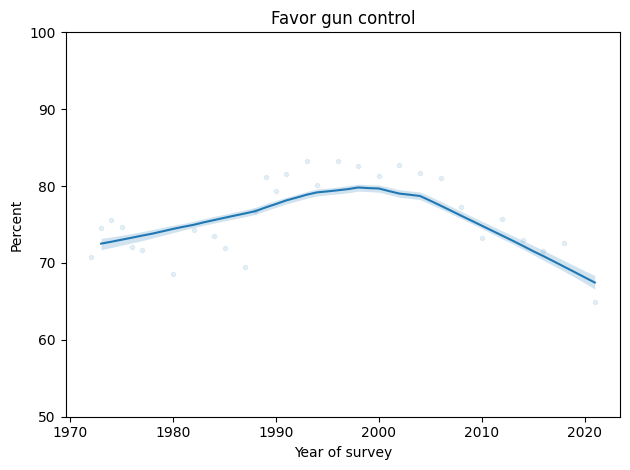

In [144]:
series = sample.groupby('year')['favor'].mean() * 100
series.plot(style='.', color='C0', alpha=0.1, label='')

plot_percentiles(favor_time_year, 'C0', '')

utils.decorate(title='Favor gun control',
               xlabel='Year of survey', 
               ylabel='Percent', ylim=ylim)

utils.save('gss_favor_year')

In [25]:
favor_seq = []

for sample in read_samples(101):
    grouped_year = sample.groupby('cohort5')
    favor = make_series(grouped_year, 'favor').dropna()
    favor_seq.append(favor)

Writing gss_cohort.png


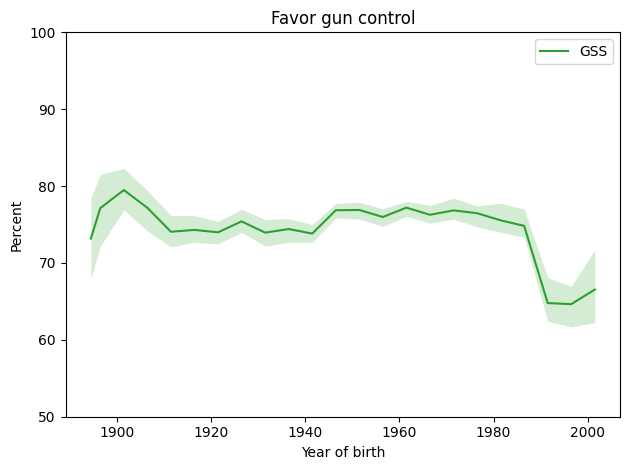

In [26]:
plot_percentiles(favor_seq, 'C2', 'GSS')
# plot_heri(heri, 'yearm18')

utils.decorate(title='Favor gun control',
                 xlabel='Year of birth', 
                 ylabel='Percent', ylim=ylim)

plt.tight_layout()
utils.save('gss_cohort')

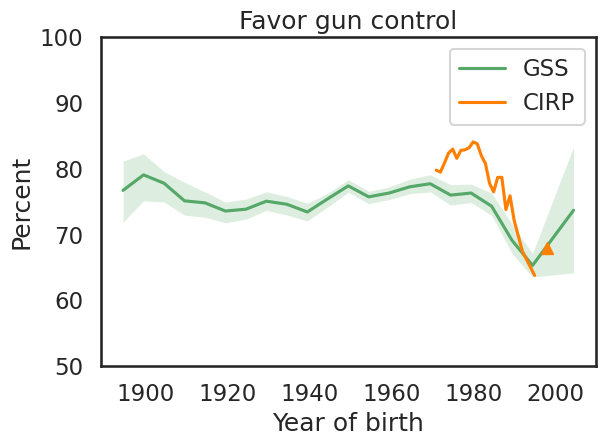

In [30]:
plot_percentiles(favor_seq, 'C2', 'GSS')
plot_heri(heri, 'yearm18')

utils.decorate(title='Favor gun control',
                 xlabel='Year of birth', 
                 ylabel='Percent', ylim=ylim)

In [31]:
favor_seq = []

for sample in read_samples(101):
    grouped_year = sample.groupby('age5')
    favor = make_series(grouped_year, 'favor').dropna()
    favor_seq.append(favor)

Writing gss_age.png


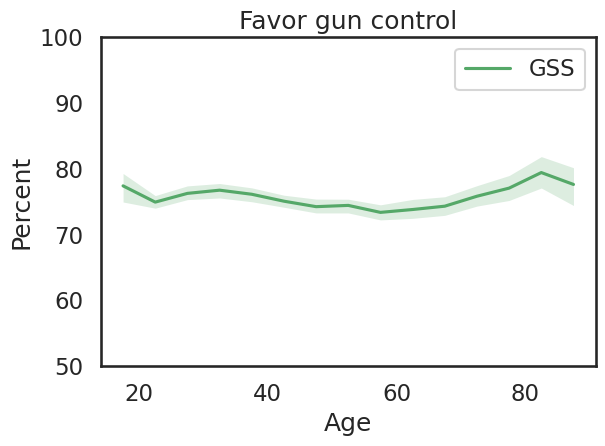

In [32]:
plot_percentiles(favor_seq, 'C2', 'GSS')

utils.decorate(title='Favor gun control',
                 xlabel='Age', 
                 ylabel='Percent', ylim=ylim)

plt.tight_layout()
utils.save('gss_age')

In [33]:
for sample in read_samples(1):
    pass

sample.shape

(45546, 59)

In [34]:
def make_result(sample, var1, var2, bad_names):
    percents = {}
    grouped_var1 = sample.groupby(var1)
    for name, group in grouped_var1:
        if name in bad_names:
            continue
        #print(name, len(group))
        grouped_var2 = group.groupby(var2)
        percents[name] = grouped_var2['favor'].mean() * 100
        
    return pd.DataFrame(percents)

In [35]:
def make_counts(sample, var1, var2):
    counts = {}
    grouped_var1 = sample.groupby(var1)
    for name, group in grouped_var1:
        grouped_var2 = group.groupby(var2)
        counts[name] = grouped_var2['favor'].count()
        
    return pd.DataFrame(counts)

## Grouped by cohort, plotted by year

In [36]:
plt.rcParams["figure.figsize"] = (7.5,4)

Float64Index([1940.0, 1950.0, 1960.0, 1970.0, 1980.0, 1990.0], dtype='float64')


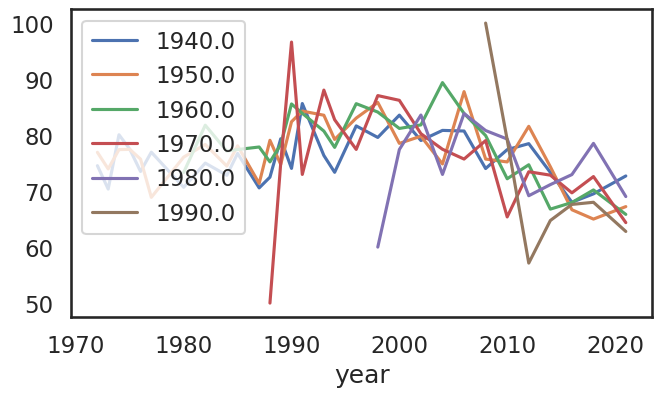

In [37]:
badnames = [1880, 1890, 1900, 1910, 1920, 1930, 2000]
result = make_result(sample, 'cohort10', 'year', badnames)
result.plot()
print(result.columns)

In [38]:
counts = make_counts(sample, 'cohort10', 'year')

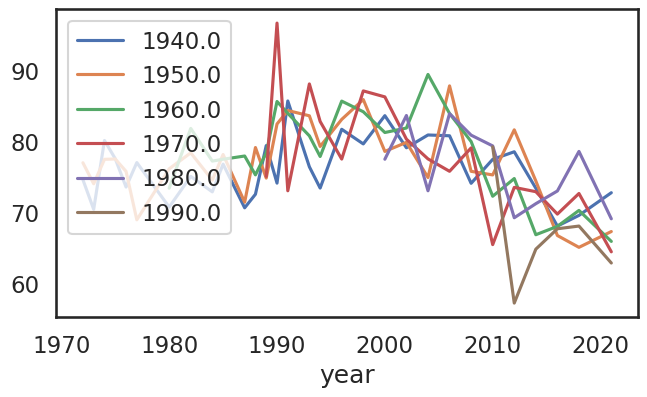

In [39]:
result = result[counts>20]
result.plot();

In [40]:
result_seq = [make_result(sample, 'cohort10', 'year', badnames)
              for sample in read_samples()];

In [41]:
result_seq = [result[counts>20] for result in result_seq];

In [42]:
def cohort_label(column):
    return '%0.0fs' % column

def age_label(column):
    return '%0.0fs' % (column-5)

Writing gss_cohort_year.png


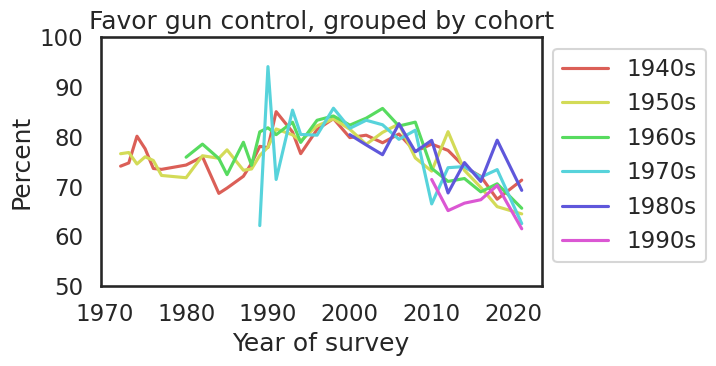

In [43]:
columns = result_seq[0].columns
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series_seq = [result[column] for result in result_seq]
    label = cohort_label(column)
    plot_percentiles(series_seq, colors[i], label, fill=False)

utils.decorate(title='Favor gun control, grouped by cohort',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim)

def savefig(root):
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.tight_layout()
    utils.save(root)
    
savefig('gss_cohort_year')

## Grouped by age, plotted by year

Float64Index([15.0, 25.0, 35.0, 45.0, 55.0, 65.0, 75.0, 85.0], dtype='float64')


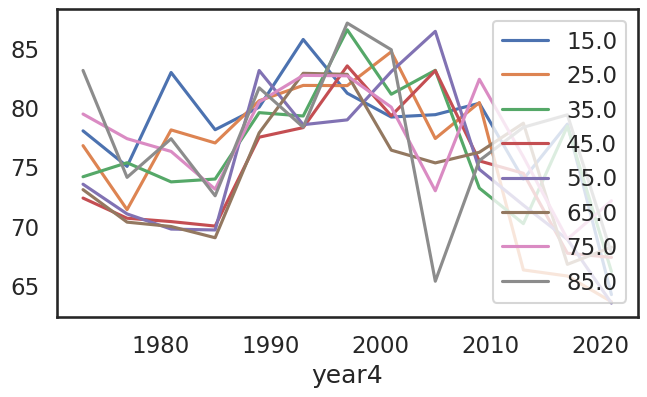

In [44]:
badnames = []
result = make_result(sample, 'age10', 'year4', badnames)
result.plot()
print(result.columns)

In [45]:
result_seq = [make_result(sample, 'age10', 'year4', badnames)
              for sample in read_samples()];

Writing gss_age_year.png


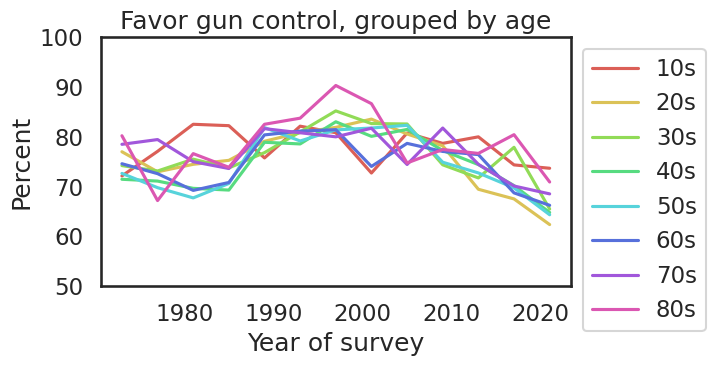

In [46]:
columns = result_seq[0].columns
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series_seq = [result[column] for result in result_seq]
    label = age_label(column)
    plot_percentiles(series_seq, colors[i], label, fill=False)

utils.decorate(title='Favor gun control, grouped by age',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim)

savefig('gss_age_year')

## Grouped by cohort, plotted by age

Float64Index([1930.0, 1940.0, 1950.0, 1960.0, 1970.0, 1980.0, 1990.0, 2000.0], dtype='float64')


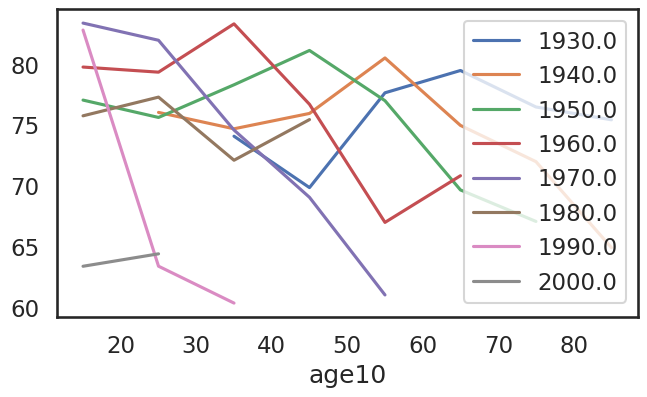

In [47]:
badnames = [1880.0, 1890.0, 1900.0, 1910.0, 1920.0]
result = make_result(sample, 'cohort10', 'age10', badnames)
result.plot()
print(result.columns)

In [48]:
result_seq = [make_result(sample, 'cohort10', 'age10', badnames)
              for sample in read_samples()];

In [49]:
columns = result_seq[0].columns[:-1]

Writing gss_cohort_age.png


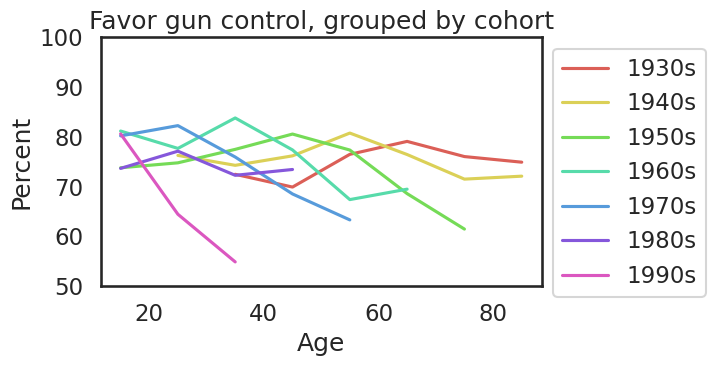

In [50]:
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series_seq = [result[column] for result in result_seq]
    label = cohort_label(column)
    plot_percentiles(series_seq, colors[i], label, fill=False)

utils.decorate(title='Favor gun control, grouped by cohort',
                 xlabel='Age', 
                 ylabel='Percent', ylim=ylim)

savefig('gss_cohort_age')

## Grouped by year, plotted by age

Int64Index([1968, 1976, 1984, 1992, 2000, 2008, 2016], dtype='int64')


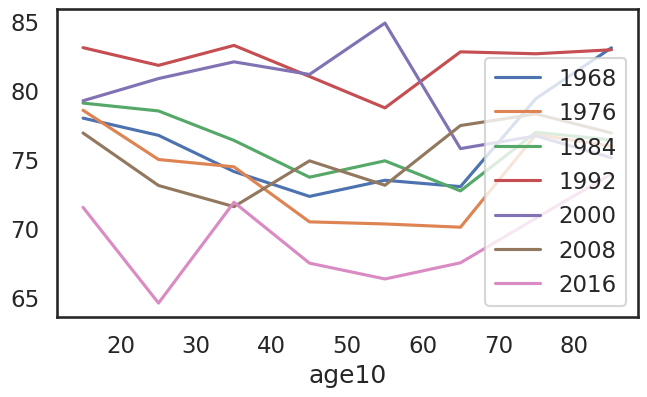

In [51]:
badnames = []
result = make_result(sample, 'year8', 'age10', badnames)
result.plot()
print(result.columns)

In [52]:
counts = make_counts(sample, 'year8', 'age10')

In [53]:
result_seq = [make_result(sample, 'year8', 'age10', badnames)
              for sample in read_samples()];

In [54]:
result_seq = [result[counts>20] for result in result_seq];

Writing gss_year_age.png


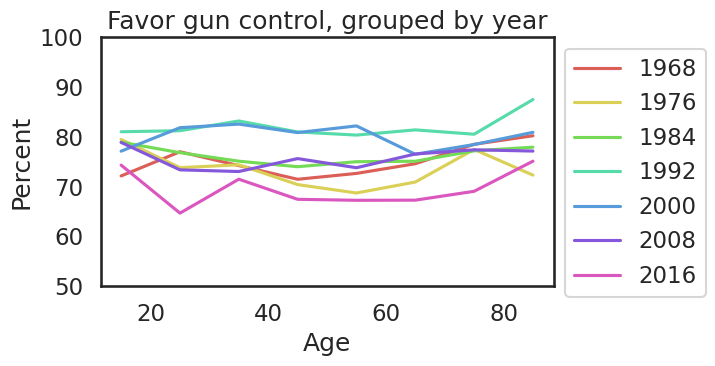

In [55]:
columns = result_seq[0].columns
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series_seq = [result[column] for result in result_seq]
    label = column
    plot_percentiles(series_seq, colors[i], label, fill=False)

utils.decorate(title='Favor gun control, grouped by year',
                 xlabel='Age', 
                 ylabel='Percent', ylim=ylim)

savefig('gss_year_age')

## Grouped by year, plotted by cohort

Int64Index([1968, 1976, 1984, 1992, 2000, 2008, 2016], dtype='int64')


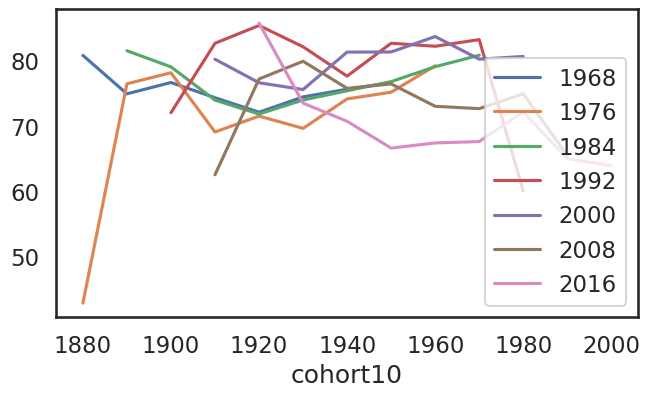

In [56]:
badnames = []
result = make_result(sample, 'year8', 'cohort10', badnames)
result.plot()
print(result.columns)

In [57]:
result_seq = [make_result(sample, 'year8', 'cohort10', badnames)
              for sample in read_samples()];

Writing gss_year_cohort.png


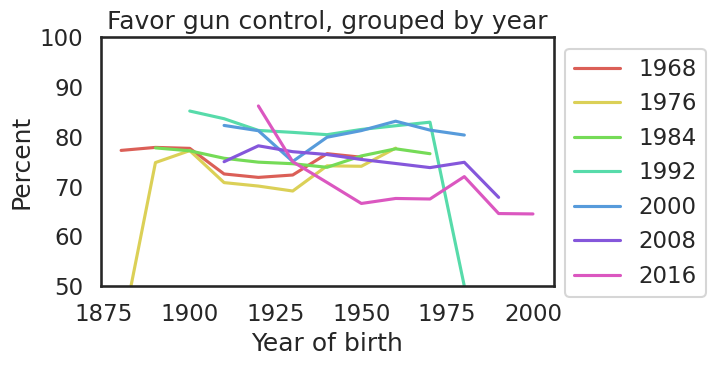

In [58]:
columns = result_seq[0].columns
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series_seq = [result[column] for result in result_seq]
    label = column
    plot_percentiles(series_seq, colors[i], label, fill=False)

utils.decorate(title='Favor gun control, grouped by year',
                 xlabel='Year of birth', 
                 ylabel='Percent', ylim=ylim)

savefig('gss_year_cohort')

## Grouped by age, plotted by cohort

Float64Index([15.0, 25.0, 35.0, 45.0, 55.0, 65.0, 75.0, 85.0], dtype='float64')


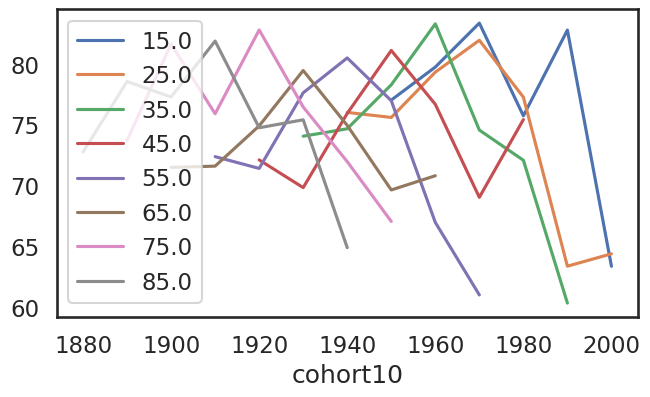

In [59]:
badnames = []
result = make_result(sample, 'age10', 'cohort10', badnames)
result.plot()
print(result.columns)

In [60]:
result_seq = [make_result(sample, 'age10', 'cohort10', badnames)
              for sample in read_samples()];

Writing gss_age_cohort.png


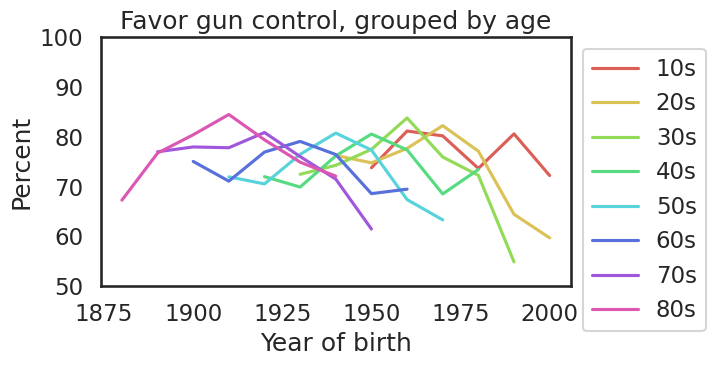

In [61]:
columns = result_seq[0].columns
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series_seq = [result[column] for result in result_seq]
    label = age_label(column)
    plot_percentiles(series_seq, colors[i], label, fill=False)

utils.decorate(title='Favor gun control, grouped by age',
                 xlabel='Year of birth', 
                 ylabel='Percent', ylim=ylim)

savefig('gss_age_cohort')

## Pew data

In [62]:
def read_pew():
    pew = pd.read_csv('Pew Gun Data - Sheet2.csv', header=None).transpose()
    pew = pew.drop(columns=[1,3,5,7])
    pew.columns = ['Date', 'Silent', 'Boomer', 'Gen X', 'Millennial']
    pew = pew.drop(0)
    date = pd.DatetimeIndex(pew.Date)
    pew.index = date.year + date.dayofyear / 365
    pew.replace(['--'], np.nan, inplace=True)
    return pew

In [63]:
pew = read_pew()

Writing pew_cohort_year.png


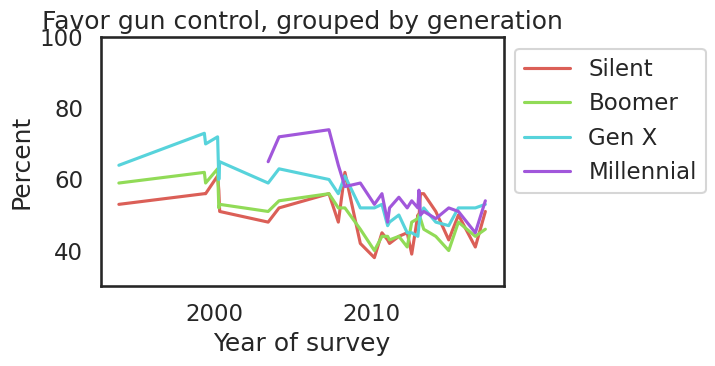

In [64]:
columns = pew.columns[1:]
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series = pew[column].astype(float)
    plt.plot(series.index, series.values, color=colors[i], label=column)

utils.decorate(title='Favor gun control, grouped by generation',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=[30, 100])

savefig('pew_cohort_year')

In [65]:
def read_pew():
    pew = pd.read_csv('Pew Gun Data - Sheet3.csv', header=None).transpose()
    pew = pew.drop(columns=[1,3,5,7])
    pew.columns = ['Date', '18-29', '30-49', '50-64', '65+']
    pew = pew.drop(0)
    date = pd.DatetimeIndex(pew.Date)
    pew.index = date.year + date.dayofyear / 365
    return pew

In [66]:
pew = read_pew()

Writing pew_age_year.png


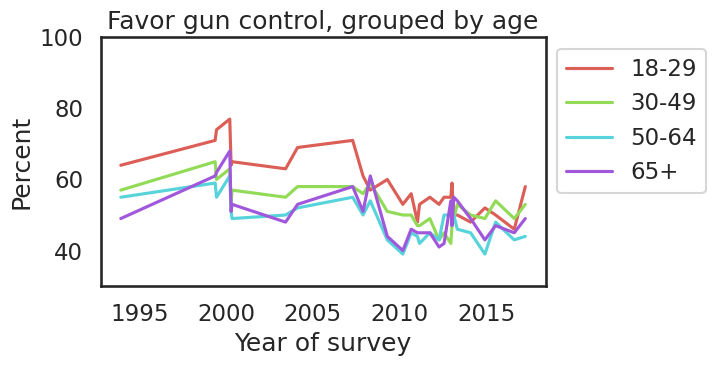

In [67]:
columns = pew.columns[1:]
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series = pew[column].astype(float)
    plt.plot(series.index, series.values, color=colors[i], label=column)

utils.decorate(title='Favor gun control, grouped by age',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=[30, 100])

savefig('pew_age_year')

## Relationship to crime

In [68]:
favor_seq = []
crime_seq = []

for sample in read_samples(101):
    grouped_year = sample.groupby('year')
    favor = make_series(grouped_year, 'favor').dropna()
    crime = make_series(grouped_year, 'spendcrime')

    favor_seq.append(favor)
    crime_seq.append(crime)

Writing gss_crime.png


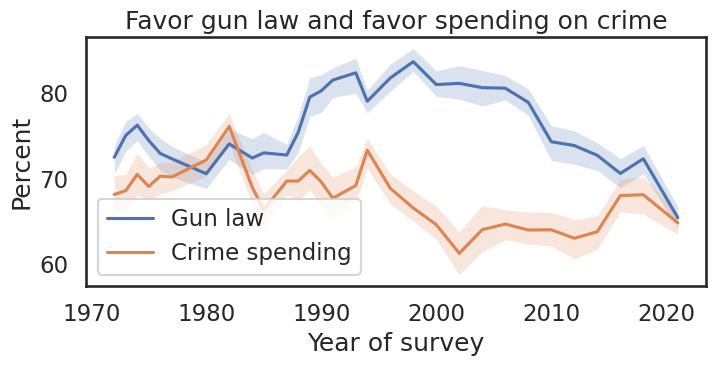

In [69]:
plot_percentiles(favor_seq, 'C0', 'Gun law')
plot_percentiles(crime_seq, 'C1', 'Crime spending')

utils.decorate(title='Favor gun law and favor spending on crime',
                 xlabel='Year of survey', 
                 ylabel='Percent')

plt.tight_layout()
utils.save('gss_crime')